# CS3630 Project 2: Vacuum Cleaning Robot (Spring 2023)


## Brief
- Due: Wed, Feb 15 at 11:59pm on Gradescope
- Hand-in: through Gradescope


## Getting started
In order to use the file as your own:
1. Click the “File” button on the toolbar at the top.
2. Click “Save a Copy”.
3. Work on the project within the copy (it will say “Copy of…”).

## Submission Instructions

### For Code
In order to submit the file, once you complete the project:
1. Click the “File” button on the toolbar at the top.
2. Click “Download”.
3. And then click “Download .ipynb”.
4. You will now have the .ipynb file on your local machine.
5. Make sure it is named `project2.ipynb`.
6. Submit the `project2.ipynb` file to Gradescope under "Project 2 - Code".

### For Reflection Questions
You should also answer the reflection questions on Gradescope under "Project 2 - Report".

# Introduction
Welcome to your second project in CS3630 (Spring 2023)!

In this project, we will be building a vacuum cleaning robot as illustrated in the [textbook](http://www.roboticsbook.org/intro.html). We want the robot to infer where it is in the world given sensor values and observations using Markov Decision Processes. Please refer to [Chapter 3](http://www.roboticsbook.org/S30_vacuum_intro.html) of the book for a more detailed description of the scenario. **This project is basically based on Chapter 3 of the textbook. Please use the same numbers and data in the textbook for each TODO.**

## Setup

RERUN THE SETUP CODE EVERYTIME YOU START.

DON'T CHANGE THE SETUP CODE! PLEASE START TO WORK FROM SECTION 3.1.



In [1]:
#Need to run this everytime the notebook gets disconnected
# %pip install -q -U gtbook

Run this code block to import the necessary packages.

In [2]:
import numpy as np
import gtsam
import pandas as pd
import time
import gtbook
from gtbook.display import show
from gtbook.discrete import Variables
VARIABLES = Variables()
def pretty(obj): 
    return gtbook.display.pretty(obj, VARIABLES)
def show(obj, **kwargs): 
    return gtbook.display.show(obj, VARIABLES, **kwargs)

import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"
from enum import Enum

Run this code block to setup the discrete state, action, and observation spaces.

In [3]:
# Constants. DON'T CHANGE THE VARIABLE NAMES AND VALUES
ACTIONS = ["L", "R", "U", "D",]
ROOMS = ["Living Room", "Kitchen", "Office", "Hallway", "Dining Room"]
LIGHT_LEVELS = ["dark", "medium", "light"]

Here is a rough map of the house the robot is operating in:

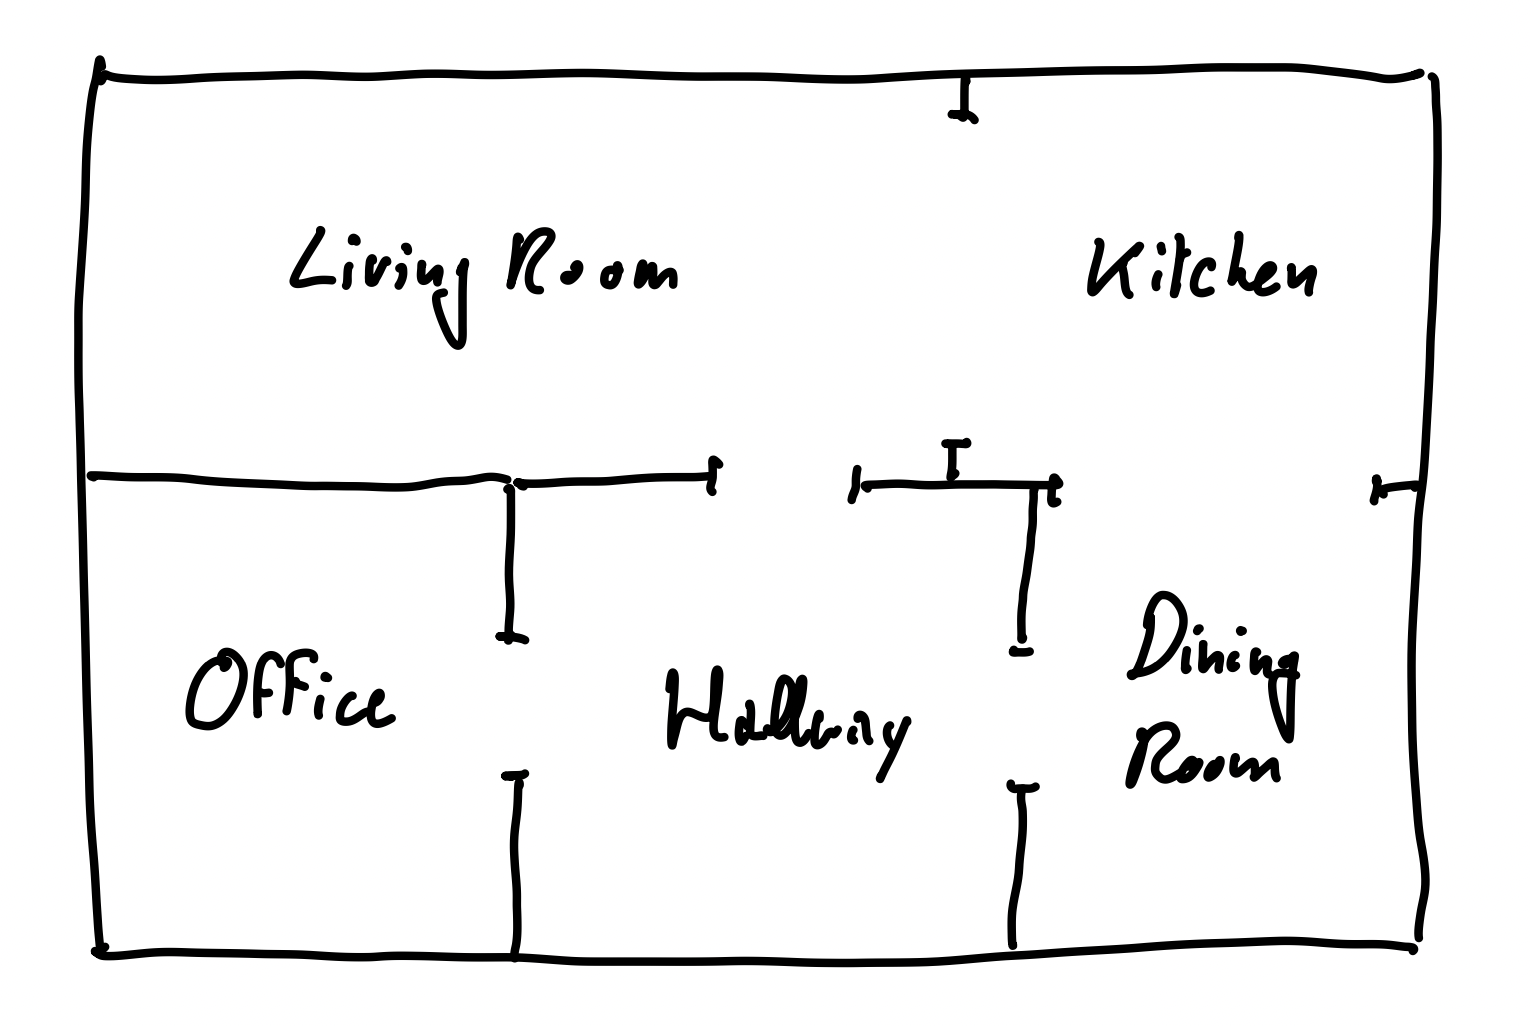

#**Section 3.1: Modeling the State Space**
In this project, we are building a *smart* home vacuum cleaning robot: RoomBuzz! Our robot will be able to infer our current state based on its actions and observations. Our robot operates under a discrete time series, so at each timestep we can figure out where the robot is in the world. To do this, we must first model our state and action space. This can be done easily with GTSAM Variables!

In order to understand the API of Variables, run the following cell after uncommenting. We want to create a **discrete time series** to represent the robot's states and actions at each discrete timestep. This is a dictionary mapping timestep values to states/actions taken in the respective timestep.

In [4]:
# help(VARIABLES)

Now, let's define methods to create the RoomBuzz's states and actions at every timestep. You can find the ACTION and STATE constants at the top of the notebook.

Create a discrete series of actions with indices as keys and actions as values.

In [5]:
# TODO 1
def create_action_series(action_variable_char, indices):
  """
  Returns a discrete series of actions

      Parameters:
          action_variable_char (str): a single character assigned to the action state variable
          indices (list of ints): a list of integer indices 

      Returns:
          A (dict): a dictionary with the keys being integer indices and the values
                    being gtsam.DiscreteKeys
  """
  A = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ###############################################################################
  A = VARIABLES.discrete_series(action_variable_char, indices, ACTIONS)
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return A

Create a discrete series of states with indices as keys and rooms as values.

In [6]:
# TODO 2 
def create_state_series(state_variable_char, indices):
  """
  Returns a discrete series of rooms

      Parameters:
          state_variable_char (str): a single character assigned to the room state variable
          indices (list of ints): a list of integer indices 

      Returns:
          X (dict): a dictionary with the keys being integer indices and the values
                    being gtsam.DiscreteKeys
  """
  X = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  X = VARIABLES.discrete_series(state_variable_char, indices, ROOMS)
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return X

Let's see if your code properly creates the state and action series:

In [7]:
A = None
X = None

if __name__ == '__main__':
  A = create_action_series("A", [1, 2, 3, 4])
  print("Action series:", A)

  X = create_state_series("X", [1, 2, 3, 4, 5])
  print("State series:", X)

Action series: {1: (4683743612465315841, 4), 2: (4683743612465315842, 4), 3: (4683743612465315843, 4), 4: (4683743612465315844, 4)}
State series: {1: (6341068275337658369, 5), 2: (6341068275337658370, 5), 3: (6341068275337658371, 5), 4: (6341068275337658372, 5), 5: (6341068275337658373, 5)}


Don't worry if you see large integer key values; the DiscreteKeys are instances of gtsam.Symbol, storing the character and the timestep value.

## Reflection Questions

1.1) Identify whether the following situations follow a Bayesian or Frequentist approach. Give a short explanation why.

1. Find the probability of getting to CS 3630 class on time
2. Find whether a coin is biased or not
3. Find how long it will take for RoomBuzz to run out of charge

1.2) Suppose RoomBuzz needs to charge every night, but the charger is located in the Office. RoomBuzz's robust software will consistently route it to the charger at the end of the day. What is the prior probability distribution of the robot's state every morning?

# **Section 3.2: Probabilistic Outcomes**

Unfortunately, RoomBuzz cannot identify the room it is in definitively. Therefore, the outcome of its actions are probabilistic; there are transition probabilities for the robot to move between rooms. To model this uncertainty, we can create a **motion model** for the robot, defining the conditional probability of the robot reaching a certain state in the next timestep given the current state and action taken:

$P(X_{t + 1}|X_t, A_t)$

To find the next state, given priors $b_s$ and motion model $M_a$, we can do the following matrix multiplication:

$b_{s'}=M_ab_s$

Here is the state transition diagram for RoomBuzz:

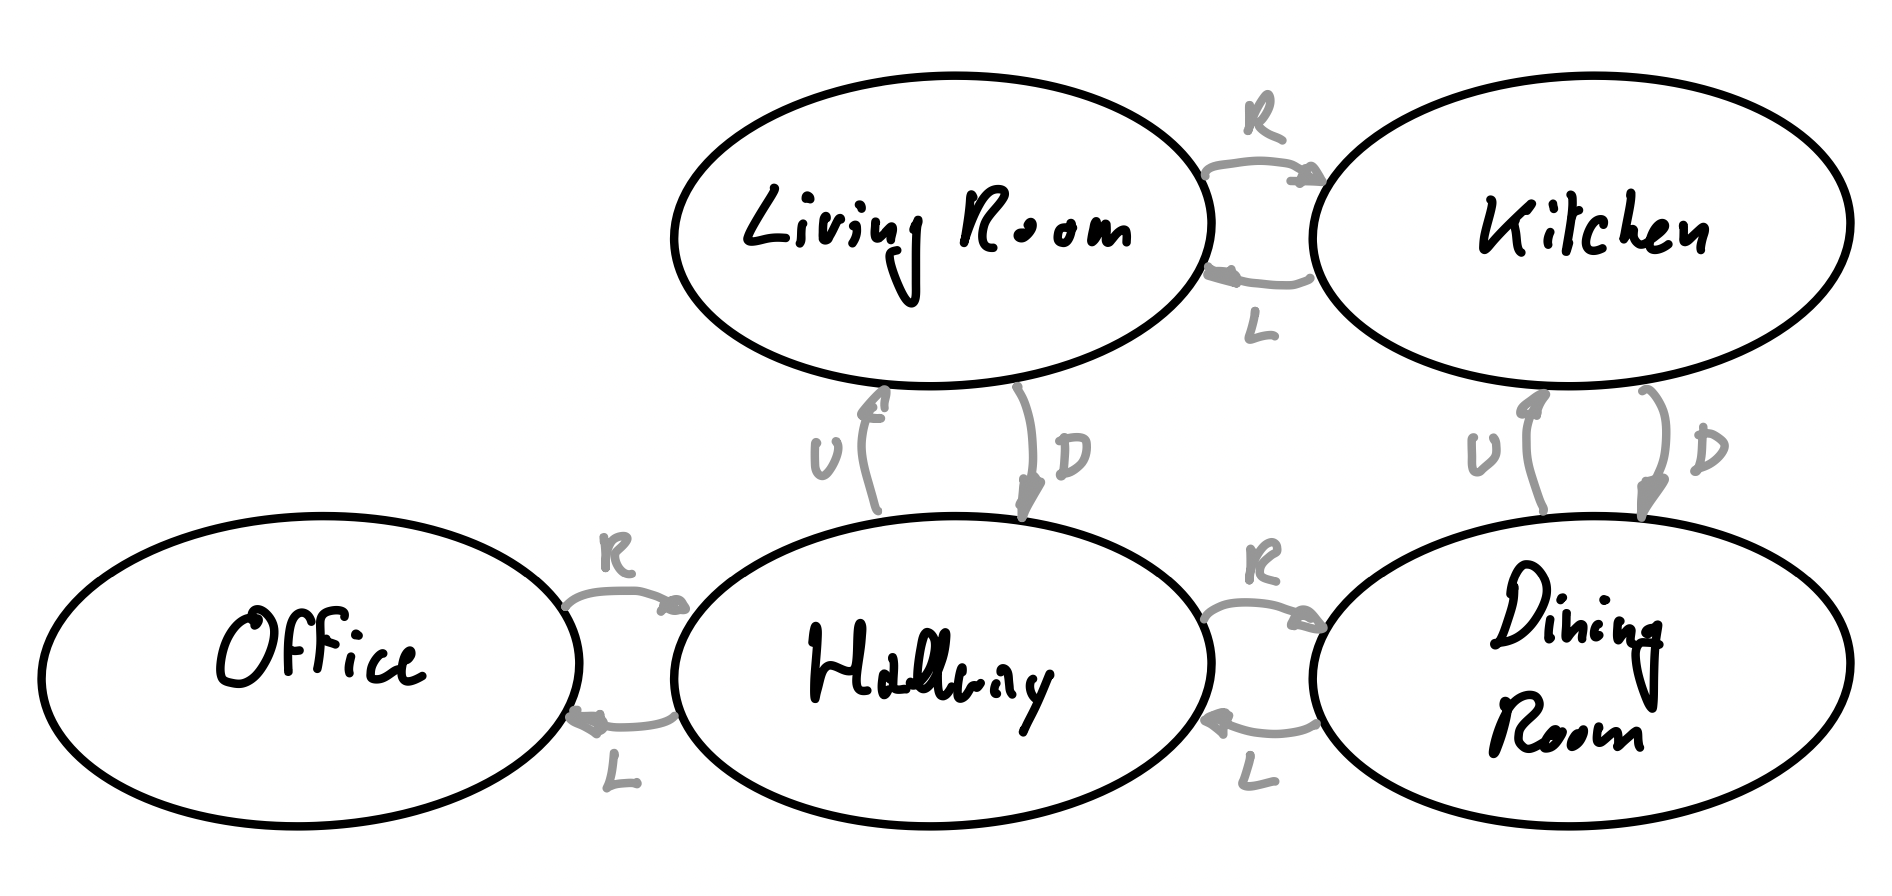

Create a motion model for RoomBuzz, which is a conditional probability table (CPT) mapping states and actions to future states. 

In [8]:
# TODO 3
def create_motion_model(states, actions, action_spec):
  """
  Returns a motion model that describes state transitions P(X2|X1, A1)

      Parameters:
          states (dict): a discrete series of states (rooms)
          actions (dict): a discrete series of actions
          action_spec (str): a table that contains all possible values for P(X2|X1, A1)

      Returns:
          motion_model (gtsam.DiscreteConditional): a DiscreteConditional that 
          describes the state transition model P(X2|X1, A1)
  """
  motion_model = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  A = actions
  X = states
  motion_model = gtsam.DiscreteConditional(X[2], [X[1], A[1]], action_spec)
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return motion_model


Run the following code block to define our CPT and motion model.

In [9]:
pretty_motion_model = None

if __name__ == '__main__':
  prob_spec = """
      1/0/0/0/0 2/8/0/0/0 1/0/0/0/0 2/0/0/8/0
      8/2/0/0/0 0/1/0/0/0 0/1/0/0/0 2/0/0/0/8
      0/0/1/0/0 0/0/2/8/0 0/0/1/0/0 0/0/1/0/0
      0/0/8/2/0 0/0/0/2/8 8/0/0/2/0 0/0/0/1/0
      0/0/0/8/2 0/0/0/0/1 0/8/0/0/2 0/0/0/0/1
      """
    
  model = create_motion_model(X, A, prob_spec)
  pretty_motion_model = pretty(model)


pretty_motion_model

X1,A1,Living Room,Kitchen,Office,Hallway,Dining Room
Living Room,L,1,0,0,0,0
Living Room,R,0.2,0.8,0,0,0
Living Room,U,1,0,0,0,0
Living Room,D,0.2,0,0,0.8,0
Kitchen,L,0.8,0.2,0,0,0
Kitchen,R,0,1,0,0,0
Kitchen,U,0,1,0,0,0
Kitchen,D,0.2,0,0,0,0.8
Office,L,0,0,1,0,0
Office,R,0,0,0.2,0.8,0


Using this motion model, we can create a Discrete Bayes Net which provides a graphical interpretation of our state transition.

In [10]:
# TODO 4
def create_bayes_net(motion_model):
  """
  Returns a discrete bayes net of the motion model P(X2|X1, A1)

      Parameters:
          motion_model (gtsam.DiscreteConditional): a DiscreteConditional that describes the state transition model P(X2|X1, A1)

      Returns:
          bayes_net (gtsam.DiscreteBayesNet): a DiscreteBayesnet that describes the motion model
  """
  bayes_net = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ###############################################################################
  bayes_net = gtsam.DiscreteBayesNet()
  bayes_net.add(motion_model)
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return bayes_net

Run the following code block to visualize your bayes net.

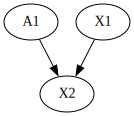

In [11]:
show_bayes_net = None

if __name__ == '__main__':
  bayes_net = create_bayes_net(model)
  show_bayes_net = show(bayes_net)

show_bayes_net

## Reflection Questions

2.1) It's the beginning of the day, and RoomBuzz undocks from its charger in the Office. It chooses action "R" in order to clean the Hallway. What is the probability that RoomBuzz ends up in the Hallway? *(Hint: Use the motion model given in Section 3.2.2 of the textbook)*

2.2) RoomBuzz has an 80/20 chance of being in the Living Room or Office, respectively. It takes action "R". What is the Probability Mass Function (PMF) over RoomBuzz's resulting belief state? *(Hint: Use the motion model given in Section 3.2.2 of the textbook)*

# **Section 3.3: Dynamic Bayes Nets**

Note that RoomBuzz's environment consists only of five states; thus it's not unreasonable to assume that it may return to a previous state. We can address this by unraveling time to remove cycles in our Bayes Net.

To improve RoomBuzz's accuracy, the team has decided to add a light sensor to the machine! This introduces the concept of observations in our DBN as well, which result from the current state. First, let's create a discrete series for the sensor measurements, with indices (discrete timesteps) as keys mapping to sensor measurements:

In [12]:
# TODO 5
def create_sensor_series(sensor_variable_char, indices):
  """
  Returns a discrete series of light levels

      Parameters:
          sensor_variable_char (str): a single character assigned to the light levels state variable
          indices (list of ints): a list of integer indices 

      Returns:
          Z (dict): a dictionary with the keys being integer indices and the values
                    being gtsam.DiscreteKeys
  """
  Z = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  Z = VARIABLES.discrete_series(sensor_variable_char, indices, LIGHT_LEVELS)
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return Z

Let's create the sensor series with five timesteps.

In [13]:
Z = None
if __name__ == '__main__':
  Z = create_sensor_series("Z", [1, 2, 3, 4, 5])
  print("Measurement series:", Z)

Measurement series: {1: (6485183463413514241, 3), 2: (6485183463413514242, 3), 3: (6485183463413514243, 3), 4: (6485183463413514244, 3), 5: (6485183463413514245, 3)}


Let's also create some priors. Define one prior that has a uniform distribution over all rooms, and another that reflects RoomBuzz always starting in the kitchen.

In [14]:
#TODO 6
def get_prior():
  """
  Returns the priors to have uniform distribution over all the rooms.

  """
  prior = ""
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  prior = "1/1/1/1/1"
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return prior

#TODO 7
def get_kitchen_start_prior():
  """
  Change kitchen_start_prior such that it reflects the knowledge that the robot always starts at the kitchen

  """
  kitchen_start_prior = ""
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  kitchen_start_prior = "0/1/0/0/0"
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return kitchen_start_prior

Now, complete the `create_dbn` function that generates our DBN given priors, states, actions, observations, sensor and action Conditional Probability Tables, and N - the number of timesteps in the DBN.

In [15]:
#TODO 8
def create_dbn(priors, X, A, Z, sensor_spec, action_spec, N):
  """
  Return a dynamic bayes net

      Parameters:
          priors (str): the prior knowledge of the robot regards the room state
          X (dict): a discrete series of (room) states
          A (dict): a discrete series of actions
          Z (dict): a discrete series of sensor measurements (light levels)
          sensor_spec (str): A table that contains all possible values of P(Z1|X1)
          action_spec (str): A table that contains all possible values of P(X2|X1, A1)
          N: number of states for the DBN

      Returns:
          dbn (gtsam.DiscreteBayesNet): the dynamic bayes net that represents the evolution of the (room) state over time
  """
  dbn = None 
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  dbn = gtsam.DiscreteBayesNet()

  for k in range(1,N+1):
    dbn.add(Z[k], [X[k]], sensor_spec) # Add measurement CPTs

  for k in reversed(range(1, N)):
    dbn.add(X[k+1], [X[k], A[k]], action_spec) # Add transition CPTs

  dbn.add(X[1], priors) # Add initial state CPT
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return dbn


Run this code block to test if your DBN is being properly generated.

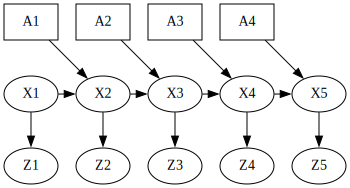

In [16]:
# NOTE: You may need to rerun this cell once in a while to reset your DBN.
# Also, feel free to test different priors when doing ancestral sampling.

show_dbn = None

priors = get_prior()
action_spec = """
    1/0/0/0/0 0/1/0/0/0 1/0/0/0/0 0/0/0/1/0
    1/0/0/0/0 0/1/0/0/0 0/1/0/0/0 0/0/0/0/1
    0/0/1/0/0 0/0/0/1/0 0/0/1/0/0 0/0/1/0/0
    0/0/1/0/0 0/0/0/0/1 1/0/0/0/0 0/0/0/1/0
    0/0/0/1/0 0/0/0/0/1 0/1/0/0/0 0/0/0/0/1
    """
sensor_spec = "1/1/8 1/1/8 2/7/1 8/1/1 1/8/1"
N = 5

if __name__ == '__main__':
  X = create_state_series("X", range(1, N+1))
  A = create_action_series("A", range(1, N))
  Z = create_sensor_series("Z", range(1, N+1))
  dbn = create_dbn(priors, X, A, Z, sensor_spec, action_spec, N)
  show_dbn = show(dbn, hints={"A":2, "X":1, "Z":0}, boxes={A[k][0] for k in range(1,N)})

show_dbn

**What is ancestral sampling?**
Ancestral sampling is done by performing state transformations from a topological sorting of the DBN. This is the same as simulating the robot over time based on the DBN you just created. 
We sample the initial state from the prior distribution $x_t \sim P(X_t)$, sample the observation from its CPT $o_t \sim P(O_t | X_t=x_t)$, and finally sample the next state from the motion model $x_{t + 1} \sim P(X_{t+1}|X_t=x_t, A_t=a_t)$.

To perform ancestral sampling let's first create some action sequences so that we can simulate our DBN. Create an action sequence consisting only of left actions, and another that is only left actions except for the final action, which is up.

In [17]:
#TODO 9
def create_all_left_action_sequence(A, num_actions):
  """
  Return an action sequence such that all actions within the sequence are "L" (left)

      Parameters:
          A: Actions dictionary
          num_actions (int): number of actions within the sequence

      Returns:
          action_seq (dict): a dictionary with the key being the action state variable (for instance, "A1", "A2", ...)
                             and the value being the left action "L"
  """
  action_seq  = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ###############################################################################
  action_seq = {A[k+1] : "L" for k in range(0, num_actions)}
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return action_seq

#TODO 10
def create_custom_action_sequence(A, num_actions):
  """
  Return an action sequence such that all actions within the sequence are "L" (left) except the last action being "U" (up)
  For example, if num_action is 1, then action sequence is {"A1": "U"}
               if num_action is 2, then action sequence is {"A1": "L", "A2": "U"}
               if num_action is 3, then action sequence is {"A1": "L", "A2": "L", "A3": "U"}

      Parameters:
          A: Actions dictionary
          num_actions (int): number of actions within the sequence

      Returns:
          action_seq (dict): a dictionary with the key being the action state variable (for instance, "A1", "A2", ...)
                             and the value being the specific action from "L", "R", "U", "D"
  """
  action_seq  = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ###############################################################################
  action_seq = {A[k+1] : "L" for k in range(0, num_actions)}
  action_seq[A[num_actions]] = "U"
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return action_seq


Let's see if your action sequences are being generated correctly! Run the following cell to test your action sequences.

In [18]:
if __name__ == '__main__':
  print(create_all_left_action_sequence(A, 3))
  print(create_custom_action_sequence(A, 3))

{(4683743612465315841, 4): 'L', (4683743612465315842, 4): 'L', (4683743612465315843, 4): 'L'}
{(4683743612465315841, 4): 'L', (4683743612465315842, 4): 'L', (4683743612465315843, 4): 'U'}


Now, implement ancestral sampling on the DBN. Applies an action sequence to the DBN, and uses the motion model to sample a potential state sequence.

In [19]:
#TODO 11
def ancestral_sampling(dbn, action_sequence, variables=VARIABLES):
  """
  Returns an ancestral sampling of a dynamic bayes net

      Parameters:
          dbn (gtsam.DiscreteBayesNet): the dynamic bayes net that represents the evolution of the (room) state over time
          action_sequence (dict): a dictionary with the key being the action state variable (for instance, "A1", "A2", ...)
                                  and the value being the specific action from "L", "R", "U", "D"
          variables (gtbook.discrete.Variables): the problem domain for discrete variables

      Returns:
          samples (gtsam.DiscreteValues): a DiscreteValues variable that contains key-value pairs with the key being all variables
                                          within the dynamic bayes net (for instance X1, X2, A1, A2, Z1, Z2) and the value being
                                          its corresponding sampled value
  """
  samples = None 
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  actions = variables.assignment(action_sequence)
  samples = dbn.sample(actions)
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return samples

Let's see if your ancestral sampling algorithm is running as expected. In the next block, change `test_action_sequence` using the two functions above and run ancestral sampling on them.

In [20]:
pretty_sample = None

if __name__ == '__main__':
  test_action_sequence = create_all_left_action_sequence(A, N-1)
  # test_action_sequence = create_custom_action_sequence(A, N-1)

  sample = ancestral_sampling(dbn, test_action_sequence)
  pretty_sample = pretty(sample)

pretty_sample

Variable,value
A1,L
A2,L
A3,L
A4,L
X1,Living Room
X2,Living Room
X3,Living Room
X4,Living Room
X5,Living Room
Z1,medium


Congrats! You have performed ancestral sampling with RoomBuzz! Now that we can simulate our DBN, we can draw certain conclusions. Note that we can find the value of Variable from the sample using the following code:

In [21]:
if __name__ == '__main__':
  var_name = "X"
  timestep = 5
  print(ROOMS[sample[gtsam.Symbol(var_name, timestep).key()]])

Living Room


Now, write some code that runs ancestral sampling N times and returns the Kth state as a list.

In [55]:
#TODO 12
def simulate_multiple(dbn, action_sequence, N, K, variables=VARIABLES):
  """
  Runs ancestral sampling multiple times and returns the Kth state of each iteration.

      Parameters:
          dbn (gtsam.DiscreteBayesNet): the dynamic bayes net that represents the evolution of the (room) state over time
          action_sequence (dict): a dictionary with the key being the action state variable (for instance, "A1", "A2", ...)
                                  and the value being the specific action from "L", "R", "U", "D"
          N (int): number of times to simulate the dbn
          K (int): which value to return
          variables (gtbook.discrete.Variables): the problem domain for discrete variables. Use this to call ancestral sampling.        

      Returns:
          resulting_states (list): a list of strings containing the final state of ancestral sampling.
  """
  resulting_states = [] 
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ###############################################################################
  for i in range(N):
    actions = variables.assignment(action_sequence)
    samples = dbn.sample(actions)
    resulting_states.append(ROOMS[samples[gtsam.Symbol("X", K).key()]])
    ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return resulting_states

Check if the simulation is working:


In [58]:
if __name__ == '__main__':
  result = simulate_multiple(dbn, create_custom_action_sequence(A, N-1), 5, 1)
  print(result)

['Dining Room', 'Dining Room', 'Hallway', 'Kitchen', 'Hallway']


Let's plot our results in a histogram. Use `plotly` to create a histogram describing the state RoomBuzz is in at a certain timestep.

In [59]:
#TODO 13
def plot_state_histogram(state_list):
  """
  Plot a histogram showing the frequency or count of each visited state in the list provided.
  Check out https://plotly.com/python/plotly-express/ for more info about using plotly.

  Make sure to include axis titles!

      Parameters:
          state_list (list): the list of visited states
      
      Returns:
          figure (histogram): the histogram of visited states

  """
  figure = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ###############################################################################
  figure = px.histogram(state_list, nbins=len(set(state_list)))
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ############################################################################### 
  return figure 

Let's plot the histogram containing the states reached at timestep 1.

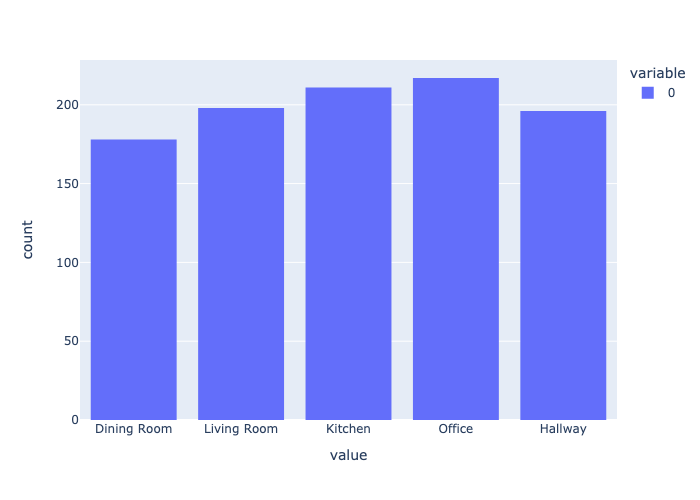

In [60]:
histogram = None

if __name__ == '__main__':
  histogram = plot_state_histogram(simulate_multiple(dbn, create_custom_action_sequence(A, N-1), 1000, 1))

histogram

## Reflection Questions
3.1) Notice that sometimes, multiple different light observations are made in the same state. Explain why. Can we use these light readings to infer what state we are in?

3.2) Run ancestral sampling 1000 times to find the **initial** state using the prior from `get_prior()` and the action sequence from `create_all_left_action_sequence()`. Plot a histogram with the results. Why do we see the resulting distribution? Paste your histogram on Gradescope.

3.3) Run ancestral sampling 1000 times to find the **final** state using the prior from `get_prior()` and the action sequence from `create_custom_action_sequence()`. Plot a histogram with the results. What do you notice? Explain why we see the resulting distribution. Paste your histogram on Gradescope.

# **Section 3.4: Perception**
This section tackles the inference problem in Hidden Markov Models; the values of certain variables are unknown, and we want to determine the most likely assignment of these variables. 

RoboBuzz also needs to be able to infer its most likely path over time given its actions taken and observations. There are multiple ways to do this, one of them being Maximum Probable Explanation (MPE). MPE iterates over all possible combinations of variable assignments and accepts the assignment with the highest likelihood. This operation is slow (exponential in the size of the input).

Recall that we represent HMM's as factor graphs; the state assignments over time are proportional to the product of the factors in the factor graph. Let's generate our factor graph and perform MPE.

In [26]:
def create_factor_graph(N):
  X = create_state_series("X", range(1, N+1))
  A = create_action_series("A", range(1, N))
  Z = create_sensor_series("Z", range(1, N+1))
  action_assignment = VARIABLES.assignment(create_custom_action_sequence(A, N-1))

  graph = gtsam.DiscreteFactorGraph()
  graph.add(X[1], "1 1 1 1 1") # \phi(X_1) = P(X_1)
  for k in range(1,N):
      conditional = gtsam.DiscreteConditional(X[k+1], [X[k], A[k]], action_spec)
      conditional_a_k = conditional.choose(action_assignment) # \phi(X,X+) = P(X+|X,A=a)
      graph.push_back(conditional_a_k)
  for k, measurement in enumerate(LIGHT_LEVELS):
      conditional = gtsam.DiscreteConditional(Z[k+1], [X[k+1]], sensor_spec)
      z_k = LIGHT_LEVELS.index(measurement)
      factor = conditional.likelihood(z_k) # \phi(X) = P(Z=z|X)
      graph.push_back(factor)
  return graph, X

Let's visualize the factor graph!

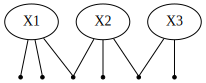

In [27]:
show_graph = None

if __name__ == '__main__':
  graph,_ = create_factor_graph(3)
  show_graph = show(graph)

show_graph

In order to perform MPE, we need to generate all possible trajectories for the factor graph.

In [28]:
def generateAllTrajactories(n, X, arr, i, trajectories_list):
    if i == n:
        trajectories_list.append(VARIABLES.assignment({X[k+1]: arr[k] for k in range(n)}))
        return

    for elem in range(5):
      arr[i] = ROOMS[elem]
      generateAllTrajactories(n, X, arr, i + 1, trajectories_list)


Finally, we can perform MPE using the `generateAllTrajectories` method above.

In [29]:
#TODO 14
def naive_MPE(graph, N, X):
  """
  Implement the function to return the value for maximum probable explanation and its corresponding state trajectory
  Hint: Use generateAllTrajectories() to populate an empty list of trajectories to iterate over.

    Parameters:
        graph (gtsam.DiscreteFactorGraph): the factor graph used to find mpe
        N: number of states
        X: states dictionary

    Returns:
        mpe_value (float): the value for maximum probable explanation
        mpe_trajectory (gtsam.DiscreteValues): the DiscreteValues variable that contains the key-value pair with the key being the
                                                (room) state variable and the value being its corresponding value
  """
  mpe_value = 0
  mpe_trajectory = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  arr = []
  generateAllTrajactories(N, X, [None] * N, 0, arr)

  for traj in arr:
    value = graph(traj)
    if value > mpe_value:
      mpe_value = value
      mpe_trajectory = traj
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################    
  return mpe_value, mpe_trajectory

Check that we are outputting the optimal trajectory:

In [30]:
if __name__ == '__main__':
  N = 6
  cur_graph, cur_X = create_factor_graph(N)
  mpe_value, mpe_trajectory = naive_MPE(cur_graph, N, cur_X)
  print(mpe_trajectory)

DiscreteValues{6341068275337658369: 3, 6341068275337658370: 2, 6341068275337658371: 2, 6341068275337658372: 2, 6341068275337658373: 2, 6341068275337658374: 2}


This is a naive MPE solution; GTSAM provides a more efficient solution. Check out DiscreteFactorGraph documentation for more information!

In [31]:
#TODO 15
def GTSAM_MPE(graph):
  """
  Implement the function to return the mpe trajectory using gtsam

      Parameters:
          graph (gtsam.DiscreteFactorGraph): the factor graph used to find mpe

      Returns:
          mpe (gtsam.DiscreteValues): the DiscreteValues variable that contains the key-value pair with the key being the
                                                 (room) state variable and the value being its corresponding value
  """
  mpe = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  mpe = graph.optimize()
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return mpe

The GTSAM MPE trajectory should match that of our Naive MPE.

In [32]:
if __name__ == '__main__':
  cur_graph, _ = create_factor_graph(N)
  mpe_trajectory = GTSAM_MPE(cur_graph)
  print(mpe_trajectory)

DiscreteValues{6341068275337658369: 3, 6341068275337658370: 2, 6341068275337658371: 2, 6341068275337658372: 2, 6341068275337658373: 2, 6341068275337658374: 2}


Is Naive MPE or GTSAM MPE better? 🤔 Now let us run both the algorithms and capture the time taken for the given number of states. Compare the naive vs GTSAM implementation running times for 3 to 9 states. Look at the graph before for an understanding on what is expected. Please include a legend and axis labels for full credit.


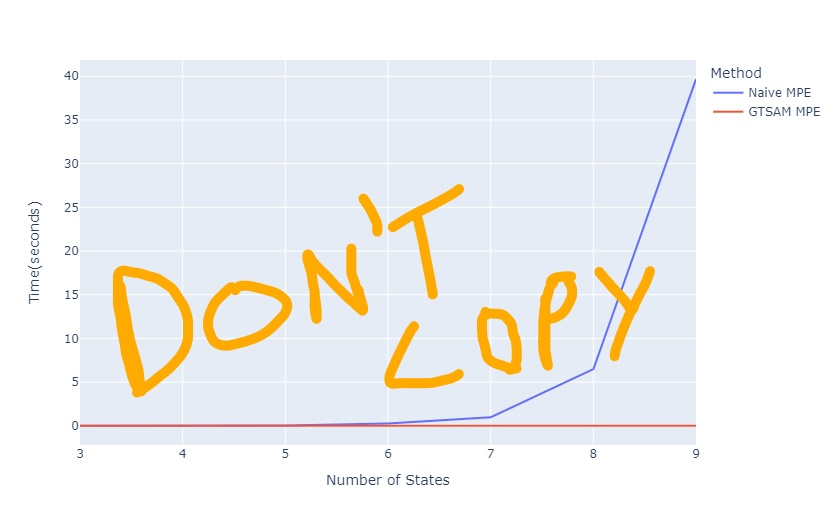

In [33]:
#TODO 16
def plot_time_complexity():
  """
  Plot the graph to compare the execution time between the naive MPE approach and the GTSAM approach.
  Check out https://plotly.com/python/plotly-express/ for more info about using plotly.

  X-axis should be N (number of states) and Y-axis should be execution time.
  """
  figure = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  mpe_list = []

  for t in range(3, 10):
    N = t
    graph, X = create_factor_graph(N)
    mpe_value,mpe_trajectory = naive_MPE(graph, N, X)
    mpe_list.append(mpe_value)

  figure = px.scatter(x=list(range(3, 10)), y = mpe_list) #This function might be useful
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return figure

Plot the running time of Naive MPE vs GTSAM MPE:

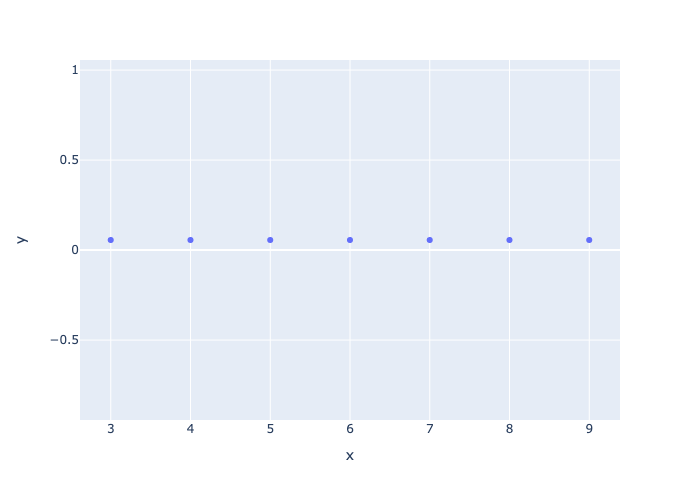

In [34]:
if __name__ == '__main__':
  fig = plot_time_complexity()
  fig.show()

## Reflection Questions
4.1) What do the following factor graphs look like: 
* If all actions and measurements are unknown?
* If actions are known but measurements are unknown?
* If actions and measurements are unknown but the state series is known?
Select the right choices from the following options:
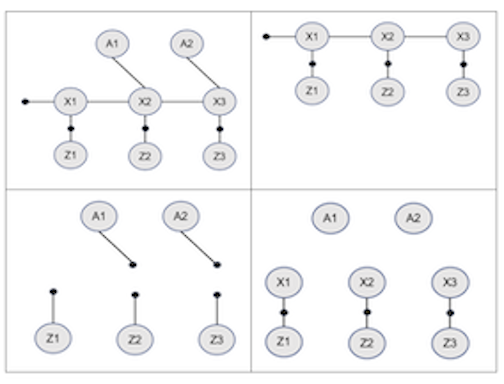


4.2) Plot the graph comparing the running time of naive MPE to GTSAM MPE. 

4.3)  What is the time complexity of MPE when enumerating over N different number of states? Choose one of the following.

* Linear ($ax+c$)      
* Cubic ($ax^3+c$)     
* Quintic ($ax^5+c$)   
* Exponential ($e^x+c$) 

# **Section 3.5: Markov Decision Processes**
As noted in the textbook, planning is the process of choosing control inputs; this leads us to the key concept of Markov Decision Processes. The decision of what actions RoomBuzz chooses to take are taken from a _policy_, which is determined through RoomBuzz finding which future state may provide it the highest _reward_.

Suppose the kitchen is very dirty. A potential reward function for RoomBuzz in this case would be 10 for entering the Kitchen, and 0 for all other states.

In learning, we also have a concept of a _policy rollout_; this is similar to simulating our DBN in Section 3.3, except we apply transition probabilities and chosen actions to find a potential state sequence for the robot.

Using this rollout, a cumulative, discounted, _rollout reward_ for being in a certain state can be found.

Run the following block to define the length of the state series, the state series, the action series and the CPT.

In [35]:
N = 5
X = VARIABLES.discrete_series("X", range(1, N+1), ROOMS)
A = VARIABLES.discrete_series("A", range(1, N), ACTIONS)
action_spec = """
      1/0/0/0/0 2/8/0/0/0 1/0/0/0/0 2/0/0/8/0
      8/2/0/0/0 0/1/0/0/0 0/1/0/0/0 2/0/0/0/8
      0/0/1/0/0 0/0/2/8/0 0/0/1/0/0 0/0/1/0/0
      0/0/8/2/0 0/0/0/2/8 8/0/0/2/0 0/0/0/1/0
      0/0/0/8/2 0/0/0/0/1 0/8/0/0/2 0/0/0/0/1
      """

Here are some functions that are critical to value/policy iteration in our MDP:

In [36]:
def reward_function(state:str, action:str, next_state:str):
    """
    Reward that returns 10 upon entering the living room.
    """
    return 10.0 if next_state == "Living Room" else 0.0

def perform_rollout(markovChain, x1, actions):
    """Roll out states given actions as a dictionary"""
    act = actions.copy()
    act[X[1]] = x1
    given = VARIABLES.assignment(act)
    return markovChain.sample(given)
  
def reward(R, rollout, A, X, k):
    """Return state, action, next_state triple for given rollout at time k."""
    state = rollout[X[k][0]]
    action = rollout[A[k][0]]
    next_state = rollout[X[k+1][0]]
    return R[state, action, next_state]

def rollout_reward(R, rollout, A, X, horizon=N-1, gamma=1.0):
    """Calculate reward for a given rollout"""
    discounted_rewards = [gamma**(k-1) * reward(R, rollout, A, X, k) for k in range(1, horizon)]
    return sum(discounted_rewards)

def get_transition_prob(action_spec):
  conditional = gtsam.DiscreteConditional((2,5), [(0,5), (1,4)], action_spec)
  T = np.empty((5, 4, 5), float)
  for assignment, value in conditional.enumerate():
      x, a, y = assignment[0], assignment[1], assignment[2]
      T[x, a, y] = value
  return T

Let's also create a markov chain to describe our robot's sequence over time.

In [37]:
#TODO 17
def create_markovChain(action_spec, N):
  """
  Implement the function such that it returns a Markov Chain 

      Parameters:
          action_spec (str): A table that contains all possible values of P(X2|X1, A1)
          N (int): number of states

      Returns:
          markovChain (gtsam.DiscreteBayesNet): a DiscreteBayeesNet that describes the Markov Chain 
  """
  X = VARIABLES.discrete_series("X", range(1, N+1), ROOMS)
  A = VARIABLES.discrete_series("A", range(1, N), ACTIONS)
  markovChain = gtsam.DiscreteBayesNet()
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  for k in range(N-1, 0, -1):
    markovChain.add(X[k+1], [X[k], A[k]], action_spec)
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return markovChain

Display the markov chain:

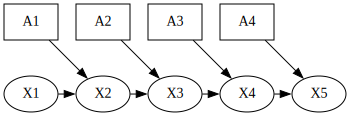

In [38]:
showMarkovChain = None

if __name__ == '__main__':
  markovChain = create_markovChain(action_spec, N)
  showMarkovChain = show(markovChain, hints={"A":2, "X":1, "Z":0}, boxes={A[k][0] for k in range(1,N)})

showMarkovChain

Now use the above functions and Markov chain to find the expected reward from a sequence of actions. First generate the reward table, and then find the reward for a given control tape.

In [39]:
#TODO 18
def generate_reward_table(action_spec):
  """
  Generates a reward table using the reward_function.
      Parameters:
          action_spec (str): A table that contains all possible values of P(X2|X1, A1)
      
      Returns:
          R (np.array): table of expected rewards given the current state

  HINT: What does the variable assignment store? How does the dimensionality of the reward table compare to the motion model?
  """
  conditional = gtsam.DiscreteConditional((2,5), [(0,5), (1,4)], action_spec)
  R = np.empty((5, 4, 5), float)
  for assignment, value in conditional.enumerate():
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ############################################################################### 
    X, A, Y = assignment[0], assignment[1], assignment[2]
    R[X, A, Y] = reward_function(ROOMS[X], A, ROOMS[Y])
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################
  return R

#TODO 19
def control_tape_reward(markovChain, x1, actions, R, A, X):
  """
  Implement the function to calculate the reward given a sequence of actions
      Parameters:
          markovChain (gtsam.DiscreteBayesNet): a DiscreteBayeesNet that describes the Markov chain
          x1 (str): the initial (room) state 
          actions (dict): the dictionary that represents a sequence of actions taken by the agent
          R (np.array): table of expected rewards given the current state
          A (dict): discrete action series
          X (dict): discrete state series
      
      Returns:
          reward (float): the final reward value given the sequence of actions
  """
  reward = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  rollout = perform_rollout(markovChain, x1, actions)
  reward = rollout_reward(R, rollout, A, X)
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  
  return reward

Let's see what our rewards are for certain action sequences.

In [40]:
R = generate_reward_table(action_spec)

if __name__ == '__main__':
  actions_1 = {A[1]:"R", A[2]:"U", A[3]:"R", A[4]:"U"}
  actions_2 = {A[1]:"R", A[2]:"U", A[3]:"U", A[4]:"U"}

  print([control_tape_reward(markovChain, "Office", actions_1,R,A,X) for i in range(10)])
  print([control_tape_reward(markovChain, "Office", actions_2,R,A,X) for i in range(10)])

[20.0, 0.0, 0.0, 0.0, 10.0, 10.0, 20.0, 0.0, 10.0, 10.0]
[20.0, 20.0, 20.0, 20.0, 0.0, 20.0, 20.0, 20.0, 0.0, 20.0]


We looked into to control tapes, but the fixed control tapes can never guarantee optimality because it can't be updated on the go. Now let us look into policies, which can be modified!

In [41]:
#TODO 20
def get_custom_policy(N):
  """
  Implements a custom policy consisting of N actions.

      Parameters:
        N (int): the number of actions needed in the policy

      Returns:
        policy (list): list of actions as indices from the ACTIONS array
  """
  policy = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ###############################################################################
  import random
  actions = [ACTIONS.index("R"), ACTIONS.index("L"), ACTIONS.index("U"), ACTIONS.index("D")]
  policy = [random.choice(actions) for i in range(N)]
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return policy

Here are some helper functions for value iteration.

In [42]:
def get_test_policy():
  RIGHT_INDEX = ACTIONS.index("R")
  LEFT_INDEX = ACTIONS.index("L")
  UP_INDEX = ACTIONS.index("U")
  DOWN_INDEX = ACTIONS.index("D")

  reasonable_policy = [RIGHT_INDEX, UP_INDEX, RIGHT_INDEX, UP_INDEX, RIGHT_INDEX]
  return reasonable_policy

def Q_value(R, T, value_function, x, a, gamma=0.9):
  """Calculate Q(x,a) from given value function"""
  return T[x,a] @ (R[x,a] + gamma * value_function)
    
def calculate_value_system(pi, R, T, gamma=0.9):
  """Calculate A, b matrix of linear system for value computation."""
  b = np.empty((5,), float)
  AA = np.empty((5,5), float)
  for x, room in enumerate(ROOMS):
      a = pi[x] # action under policy
      b[x] = T[x,a] @ R[x,a] # expected reward under policy pi
      AA[x] = -gamma * T[x,a]
      AA[x,x] += 1
  return AA,b
    
def calculate_value_function(pi, R, T, gamma=0.9):
  """Calculate value function for given policy"""
  AA, b = calculate_value_system(pi, R,T, gamma)
  return np.linalg.solve(AA,b)

You may replace the `test_policy` with `get_custom_policy()` using the parameter N.

In [43]:
test_policy = get_test_policy() #replace with your policy using get_custom_policy()
T = get_transition_prob(action_spec)

if __name__ == '__main__':
  value_for_pi = calculate_value_function(test_policy, R, T)
  print("V:")
  for i,room in enumerate(ROOMS):
      print(f"  {room:12}: {value_for_pi[i]}")

V:
  Living Room : 2.439024390243904
  Kitchen     : 2.059077589754208e-15
  Office      : 10.446743372847175
  Hallway     : 11.897679952409282
  Dining Room : 0.0


Now we must find the optimal policy for RoomBuzz! Refer to the textbook on how to perform policy iteration.

In [44]:
def update_policy(R, T, value_function):
  """Update policy given a value function"""
  new_policy = [None for _ in range(5)]
  for x, room in enumerate(ROOMS):
      Q_values = [Q_value(R, T, value_function, x, a) for a in range(4)]
      new_policy[x] = np.argmax(Q_values)
  return new_policy

Finally, we can perform policy iteration using the reward function R, transition table T, and prior pi, for max_iterations iterations.

In [45]:
#TODO 21
def policy_iteration(R, T, pi=None, max_iterations=100):
  """
  Perform policy iteration, starting from policy `pi`.

      Parameters:
          R (np.array): table of expected rewards given the current state
          T (np.array): table of state transition probabilities given actions
          pi (list): prior policy
          max_iterations (int): maximum number of times to iterate  
      
      Returns:
          pi (list): final policy after policy iteration
          value_for_pi (float): value function for the final policy
  """
  for _ in range(max_iterations):
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ############################################################################### 
    value_for_pi = calculate_value_function(pi, R, T) if pi is not None else np.zeros((5,))
    new_policy = update_policy(R, T, value_for_pi)
    if new_policy == pi:
        return pi, value_for_pi
    pi = new_policy
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################
  raise RuntimeError(f"No stable policy found after {max_iterations} iterations")   

Output the optimal policy!

In [46]:
if __name__ == '__main__':
  policy = get_test_policy() #replace with your policy using get_custom_policy()
  optimal_policy, optimal_value_function = policy_iteration(R, T, policy)
  print([ACTIONS[a] for a in optimal_policy])
  print("The optimal values at each state when the optimal policy followed:")
  for i, room in enumerate(ROOMS):
      print(f"  {room:12}: {optimal_value_function[i]}")

['L', 'L', 'R', 'U', 'U']
The optimal values at each state when the optimal policy followed:
  Living Room : 100.00000000000001
  Kitchen     : 97.56097560975611
  Office      : 85.66329565734684
  Hallway     : 97.5609756097561
  Dining Room : 85.66329565734685


## Reflection Questions

5.1) What is a rollout? What is rollout reward? 

5.2) Compare the two control tapes provided after TODO 19. What is the optimal control tape? Why?

5.3) What is the optimal policy? Give a short explanation on what this policy tells us.

5.4) What's the objective of using policy iteration? What's the objective of using value iteration?

# **Section 3.6: Reinforcement Learning (EXTRA CREDIT)**


## Getting Data

First step for any learning method is getting data. We have implemented the function `explore_randomly` to generate data for you!

In [47]:
def explore_randomly(x1, horizon=N):
    """Roll out states given a random policy, for given horizon."""
    data = []
    x = x1
    for _ in range(1, horizon):
        a = np.random.choice(4)
        next_state_distribution = gtsam.DiscreteDistribution(X[1], T[x, a])
        x_prime = next_state_distribution.sample()
        data.append((x, a, x_prime, R[x, a, x_prime]))
        x = x_prime
    return data

Write a function which returns data from the Hallway with a horizon equal to 2000.

In [48]:
#TODO 22
def generate_data():
  """Return the data from the Hallway with horizon 2000"""
  data = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  data = explore_randomly(4, horizon=2000)
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return data

Output the resulting data.

In [49]:
if __name__ == '__main__':
  data = generate_data()
  print(data[:10]) # Prints the first 10 experiences from the generated data

[(4, 0, 4, 0.0), (4, 1, 4, 0.0), (4, 2, 1, 0.0), (1, 1, 1, 0.0), (1, 3, 4, 0.0), (4, 1, 4, 0.0), (4, 2, 1, 0.0), (1, 1, 1, 0.0), (1, 3, 4, 0.0), (4, 2, 1, 0.0)]


## Model-based Reinforcement Learning

We can estimate the transition probabilities  and reward table  from the data, and then we can use the algorithms from before to calculate the value function and/or optimal policy.

Given the reward summation and the T count, get the estimates of the Rewards and Transitions.

In [50]:
#TODO 23
def get_estimates(R_sum, T_count):
  "Estimate R and T using R_sum and T_count"
  R_estimate = None
  T_estimate = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ###############################################################################
  R_estimate = np.divide(R_sum, T_count, where=T_count!=0)
  xa_count = np.sum(T_count, axis=2)
  T_estimate = T_count/np.expand_dims(xa_count, axis=-1)
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################

  return R_estimate, T_estimate

We can test the estimate by actually simulating them.

In [51]:
if __name__ == '__main__':
  R_sum = np.zeros((5, 4, 5), float)
  T_count = np.zeros((5, 4, 5), float)
  for x, a, x_prime, r in data:
      R_sum[x, a, x_prime] += r
      T_count[x, a, x_prime] += 1

  R_estimate, T_estimate = get_estimates(R_sum, T_count)


Running next two cells will help you check the performance of the estimations.

In [52]:
if __name__ == '__main__':
  # We can compare to see the esitmate and the ground truth of T and R
  print(f"Ground truth T:\n{T[0]}")
  print(f"Estimated T:\n{np.round(T_estimate[0], 2)}")

Ground truth T:
[[1.  0.  0.  0.  0. ]
 [0.2 0.8 0.  0.  0. ]
 [1.  0.  0.  0.  0. ]
 [0.2 0.  0.  0.8 0. ]]
Estimated T:
[[1.   0.   0.   0.   0.  ]
 [0.22 0.78 0.   0.   0.  ]
 [1.   0.   0.   0.   0.  ]
 [0.2  0.   0.   0.8  0.  ]]


In [53]:
if __name__ == '__main__':
  print(f"Ground truth R:\n{R[0]}")
  print(f"Estimated R:\n{np.round(R_estimate[0], 2)}")

Ground truth R:
[[10.  0.  0.  0.  0.]
 [10.  0.  0.  0.  0.]
 [10.  0.  0.  0.  0.]
 [10.  0.  0.  0.  0.]]
Estimated R:
[[10.  0.  0.  0.  0.]
 [10.  0.  0.  0.  0.]
 [10.  0.  0.  0.  0.]
 [10.  0.  0.  0.  0.]]


## Reflection Questions

6.1) What are some of the problems that one would face while designing an RL agent?

6.2) In the given equation, please define the variables $x$, $a$, $x'$, $a'$, $\alpha$, $\gamma$, $\hat Q$, and $R$.

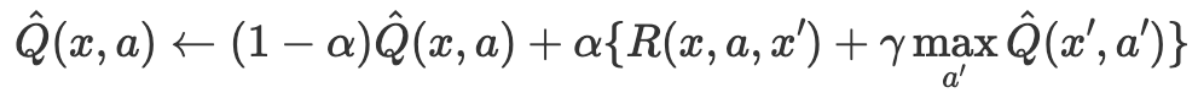

YOU ARE DONE!!!🎉🎉🥳🎉🎉